In [1]:
import torch
import pandas as pd
import numpy as np
import pickle as pkl

In [2]:
import supervised_dataset
import importlib
importlib.reload(supervised_dataset)

<module 'supervised_dataset' from '/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Supervised/supervised_dataset.py'>

In [3]:
import sys
sys.path.insert(0, '/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/geography-aware-ssl/moco_fmow/moco')
from ms_nl_resnet import MS_NL_ResNet18


/cephyr/users/benvin/Alvis/.local/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /cephyr/users/benvin/Alvis/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
for fold in ['A', 'B', 'C', 'D', 'E']:
    losses = pd.read_csv('fold_{}/losses_fold_{}_epoch_0068_.txt'.format(fold, fold), sep=",", header=None)
    best_epoch = losses[1].argmin()
    print("Best epoch: ", best_epoch)
    print("Best epoch val_loss: ", losses[1].iloc[best_epoch])

    model = MS_NL_ResNet18(num_classes=1)

    checkpoint_path = 'fold_{}/checkpoint_fold_{}_{:04d}.pth.tar'.format(fold, fold, best_epoch)
    print("Model loaded: ", checkpoint_path)
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    checkpoint_dict = dict()
    for key in checkpoint['state_dict'].keys():
        resnet_key=key.replace("module.", "")
        checkpoint_dict[resnet_key]=checkpoint['state_dict'][key]

    model.load_state_dict(checkpoint_dict)

In [4]:
fold = 'A'

losses = pd.read_csv('fold_{}/losses_fold_{}_epoch_0068_.txt'.format(fold, fold), sep=",", header=None)
best_epoch = losses[1].argmin()
print("Best epoch: ", best_epoch)
print("Best epoch val_loss: ", losses[1].iloc[best_epoch])

model = MS_NL_ResNet18(num_classes=1)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

checkpoint_path = 'fold_{}/checkpoint_fold_{}_{:04d}.pth.tar'.format(fold, fold, best_epoch)
print("Model loaded: ", checkpoint_path)
checkpoint = torch.load(checkpoint_path, map_location='cpu')

checkpoint_dict = dict()
for key in checkpoint['state_dict'].keys():
    resnet_key=key.replace("module.", "")
    checkpoint_dict[resnet_key]=checkpoint['state_dict'][key]
            
model.load_state_dict(checkpoint_dict)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Best epoch:  12
Best epoch val_loss:  120.83437824249269
Model loaded:  fold_A/checkpoint_fold_A_0012.pth.tar


<All keys matched successfully>

In [5]:
torch.cuda.set_device(0)
model.cuda(0)
print()

criterion = torch.nn.MSELoss().cuda(0)

In [6]:
csv = "/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/Supervised/dhs_clusters_paths.csv"
folds_path = '/cephyr/NOBACKUP/groups/globalpoverty1/JesperBenjamin/CreateFolds/new_dhs_incountry_folds.pkl'


with open(folds_path, 'rb') as handle:
        folds = pkl.load(handle)
        
test_dataset = supervised_dataset.SupervisedDataset(csv, csv_indices=folds[fold]['test'])

batch_size = 64
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)



In [28]:
plt.rcParams["figure.figsize"] = (20,10)

# Run eval on model

In [8]:
# TEST MODEL
iwi_pred = []
iwi_true = []

model.eval()
for i, (images, labels) in enumerate(test_loader):
    #print(images.size())
    images = images.cuda(0)
    labels = labels.cuda(0)
    
    preds = model(images)
    preds = torch.squeeze(preds)
    #print(preds.size())
    
    loss = criterion(preds, labels)
    print(loss)
    
    for pred in preds:
        iwi_pred.append(pred.item())
    
    for label in labels:
        iwi_true.append(label.item())
    
    
    #iwi_preds.extend(preds.numpy())
    
    #if i >= 0:
    #    break
    
    print("batch: ", i, "/", len(test_loader))
    print()
    
with open('preds_{}.pkl'.format(fold), 'wb') as f:
    pkl.dump(iwi_pred, f)

tensor(321.3807, device='cuda:0', grad_fn=<MseLossBackward>)


r2:  0.4337048670778558
slope:  0.509458999060509 intercept:  21.55484907833142


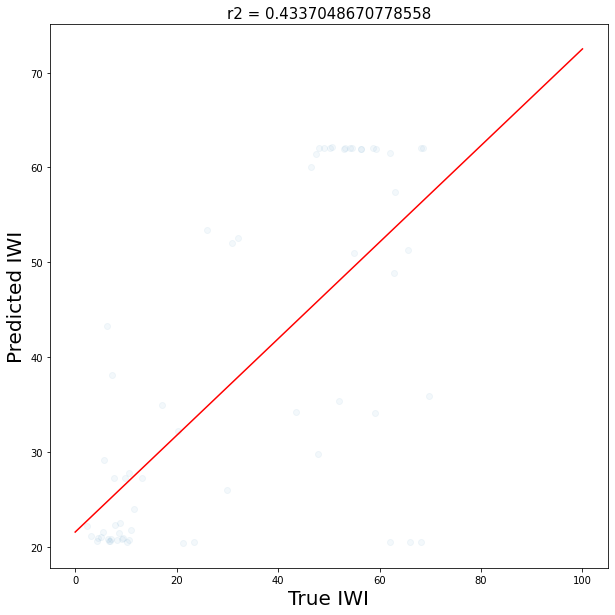

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline

r2 = r2_score(iwi_true, iwi_pred)
print("r2: ", r2)

plt.figure(figsize=(10,10))
plt.scatter(iwi_true, iwi_pred, alpha=0.05)
m, b = np.polyfit(iwi_true, iwi_pred, 1)

x = [i for i in range(101)]
y = [i*m + b for i in x]

print("slope: ", m, "intercept: ", b)

plt.title('r2 = ' + str(r2), fontsize=15)
plt.xlabel('True IWI', fontsize=20)
plt.ylabel('Predicted IWI', fontsize=20)
plt.plot(x, y, c='red')



In [138]:
lossf = criterion(torch.Tensor(iwi_pred), torch.Tensor(iwi_true))
lossf

tensor(141.2976)